# Part 3: Modeling
Welcome to the third notebook, which is the final stage in this project. In this stage, we will use the scraped cimahi house dataset which has been cleaned before, for next create and evaluate regression models to predict house price in cimahi and its surrounding. 
<br>

First, we will analyze any features in our dataset for check if the dataset has to be scaled and/or if the data has multicolinearity issues. 
<br>

After that, we will create a baseline model to predict the dataset. Then we'll evaluate our model performance and give some hyperparameter tuning to improve our model performance. In the end, we can see which independent features are the most important in influencing the target variable and we can get some conclusion.

## Importing Library

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler,OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


import seaborn as sns
import matplotlib.pyplot as plt

import  warnings

## Importing Dataset

In [2]:
df = pd.read_csv('house_model.csv')
df.tail()

,url,address,building_area,surface_area,bedroom,bathroom,parking_area,tenure,price
896,https://www.rumah123.com/properti/cimahi/hos29...,"Cimahi Selatan, Cimahi",90.0,104.0,2,2,0,SHM - Sertifikat Hak Milik,1.200000e+09
897,https://www.rumah123.com/properti/bandung/hos8...,"Lembang, Bandung Barat",590.0,756.0,11,6,0,SHM - Sertifikat Hak Milik,5.500000e+09
898,https://www.rumah123.com/properti/cimahi/hos91...,"Cimahi Utara, Cimahi",55.0,80.0,2,2,1,SHM - Sertifikat Hak Milik,7.000000e+08
899,https://www.rumah123.com/properti/bandung/hos8...,"Cihanjuang, Bandung Barat",60.0,90.0,3,1,1,SHM - Sertifikat Hak Milik,7.500000e+08
900,https://www.rumah123.com/properti/cimahi/hos82...,"Cimahi Tengah, Cimahi",100.0,102.0,4,2,0,SHM - Sertifikat Hak Milik,7.600000e+08


## Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            901 non-null    object 
 1   address        901 non-null    object 
 2   building_area  901 non-null    float64
 3   surface_area   901 non-null    float64
 4   bedroom        901 non-null    int64  
 5   bathroom       901 non-null    int64  
 6   parking_area   901 non-null    int64  
 7   tenure         901 non-null    object 
 8   price          901 non-null    float64
dtypes: float64(3), int64(3), object(3)
memory usage: 63.5+ KB


In [4]:
df.isnull().sum()

url              0
address          0
building_area    0
surface_area     0
bedroom          0
bathroom         0
parking_area     0
tenure           0
price            0
dtype: int64

In [5]:
df.shape

(901, 9)

In [6]:
df.describe()

,building_area,surface_area,bedroom,bathroom,parking_area,price
count,901.000000,901.000000,901.000000,901.000000,901.000000,9.010000e+02
mean,139.641509,226.735849,3.243063,2.221976,0.803552,1.710226e+09
std,149.122288,776.352159,2.375750,1.888446,1.742995,2.665649e+09
min,30.000000,25.000000,0.000000,0.000000,0.000000,6.670000e+06
25%,55.000000,80.000000,2.000000,1.000000,0.000000,6.500000e+08
50%,90.000000,114.000000,3.000000,2.000000,1.000000,1.000000e+09
75%,168.000000,171.000000,4.000000,3.000000,1.000000,1.700000e+09
max,2000.000000,20000.000000,34.000000,25.000000,25.000000,4.200000e+10


In [7]:
df.corr(method='spearman')

,building_area,surface_area,bedroom,bathroom,parking_area,price
building_area,1.000000,0.765195,0.742449,0.739099,0.143063,0.827780
surface_area,0.765195,1.000000,0.601469,0.594349,0.119638,0.843035
bedroom,0.742449,0.601469,1.000000,0.758446,0.194104,0.641812
bathroom,0.739099,0.594349,0.758446,1.000000,0.185853,0.691118
parking_area,0.143063,0.119638,0.194104,0.185853,1.000000,0.119187
price,0.827780,0.843035,0.641812,0.691118,0.119187,1.000000


As we can see, it turns out that our independent variables have a strong correlation with each other. This shows that in this dataset has a multicollinearity issue, so it can be solved using PCA, because if it is solved by feature selection, it is feared that it will cause underfitting.

## Data Splitting

In [8]:
# Splitting Training and Testing Set

x = df.drop(['price','url'], axis= 1)
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(x ,y ,test_size = 0.2, random_state = 42)

## Creating Baseline Model

Here, we'll create a baseline model to have a rough model without upgrading anything. First, we'll try using the general model for regression, that linear regression.

In [9]:
# Scaling and Encoding 

num_cols = ['bedroom','bathroom','building_area','surface_area','building_area']

transformer = ColumnTransformer([
    ('onehot_encoder', OneHotEncoder(drop='first'), ['tenure']),
    ('binary_encoder', ce.BinaryEncoder(), ['address']),
    ('Scaler', RobustScaler(), num_cols),
    ('PCA', PCA(n_components=3), num_cols)
],remainder = 'passthrough')

x_train_scaled = transformer.fit_transform(x_train)
x_test_scaled = transformer.transform(x_test)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Here, I use onehot encoder to encode features that have a few categories, and i use binary encoder for features that has lot categories to avoid overfitting isues. And also, I use robust scaler because they scale the data but can adjust with data which has outliers.

In [10]:
# Create a function for model evaluation

def evaluation(model):
    
    model.fit(x_train_scaled, y_train)
    y_pred_train = model.predict(x_train_scaled)
    
    print('__Training__')
    print('R-squared:',metrics.r2_score(y_train, y_pred_train))
    print('MAE:',metrics.mean_absolute_error(y_train, y_pred_train))
    print('MSE:',metrics.mean_squared_error(y_train, y_pred_train))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    
    y_pred_test = model.predict(x_test_scaled)

    print('__Validation__')
    print('R-squared:',metrics.r2_score(y_test,  y_pred_test))
    print('MAE:',metrics.mean_absolute_error(y_test, y_pred_test))
    print('MSE:',metrics.mean_squared_error(y_test, y_pred_test))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

    
    plt.figure(figsize=(7, 7))
    
    ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
    sns.distplot(y_pred_test, hist=False, color="g", label="Predict Values" , ax=ax1)

    plt.title('Actual vs Predict Values')
    plt.xlabel('Price')
    plt.ylabel('Proportion of Houses')

    plt.legend()
    plt.show()

### 1. Linear Regression

In [11]:
linreg = LinearRegression()
linreg.fit(x_train_scaled, y_train)

LinearRegression()

__Training__
R-squared: 0.8263566563656388
MAE: 558346473.2595018
MSE: 1.2027506082793795e+18
RMSE: 1096699871.5598445
__Validation__
R-squared: 0.6732913451243294
MAE: 630368208.1995871
MSE: 2.5380649077865e+18
RMSE: 1593130536.9575024


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


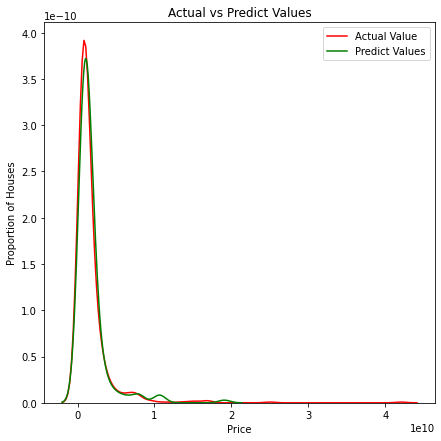

In [12]:
evaluation(linreg)

Before we checking this regression model performance, I would like to provide a simple explanation of the model's evaluation metrics :
- `R-squared` : This metric is measure of the linear relationship between X and Y. This metric interprets how strong the relationship between  independent variables is with target variable, or how well the independent variable can predict the target variable. If R-square value is close to 1, it's mean the stronger the relationship between model feature.

- `MAE` : This is the easiest to understand, because this metric measures the average value of absolute error. Generally used on datasets that have many outliers. The lower mae value that indicates a good model performance.

- `MSE` : This metric measures the average value of squared error. This metric is more popularly used than mae, because this metric punishes large values ​​or does not tolerate outliers, so as to produce better measurements. The lower mse value that indicates a good model performance.

- `RMSE` : This metric measures the standard deviation of the residuals value, this metric interprets how varied the location of the residual value is, the closer to 0 indicates a good model performance.


As we see, that there is a bad model performance on test set, and also an increase in any error value metric, so there indicates has an overfitting issue. Next, we try to apply ridge and lasso to improve this linear regression performance, because they  can reduce multicollinearity issues. This method is applied to the linear regression method, so it can also be called `Ridge Regression` and `Lasso Regression`

### 2. Ridge Regression

In [13]:
ridge = Ridge(alpha = 100000)
ridge.fit(x_train_scaled,y_train)

Ridge(alpha=100000)

__Training__
R-squared: 0.816788170323038
MAE: 535971207.28942853
MSE: 1.2690272772675333e+18
RMSE: 1126511108.36402
__Validation__
R-squared: 0.714063950196598
MAE: 574891837.7838053
MSE: 2.2213193407847823e+18
RMSE: 1490409118.5928721


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


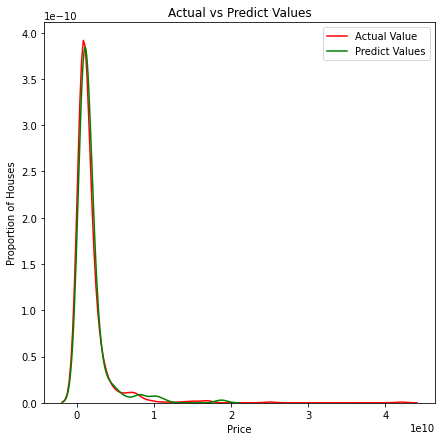

In [14]:
evaluation(ridge)

In this method, the R-squared performance  shows more stable results than linear regression and doesn't indicate multicollinearity issues. Although there is an increase in the error value.

### 3. Lasso Regression

In [15]:
lasso = Lasso(alpha = 0.1)
lasso.fit(x_train_scaled, y_train)

Lasso(alpha=0.1)

__Training__
R-squared: 0.8263566563656388
MAE: 558346473.0922744
MSE: 1.2027506082793792e+18
RMSE: 1096699871.5598445
__Validation__
R-squared: 0.6732913452174202
MAE: 630368208.0369736
MSE: 2.5380649070633165e+18
RMSE: 1593130536.7305331


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


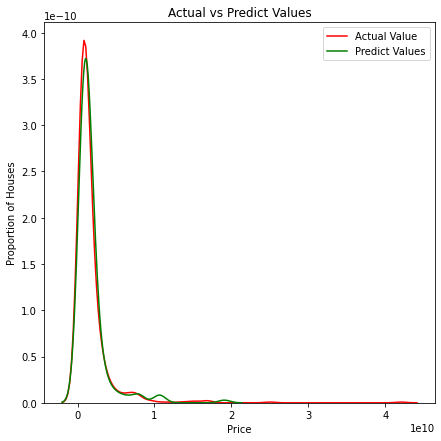

In [16]:
evaluation(lasso)

It turns out that the results still show a performance similar to linear regression. Then next we can try another basic method, `KNN`.

### 4. KNN

In [17]:
knn = KNeighborsRegressor()
knn.fit(x_train_scaled, y_train)

KNeighborsRegressor()

__Training__
R-squared: 0.7624891609901118
MAE: 412099694.4444444
MSE: 1.6451324888883336e+18
RMSE: 1282627182.3442435
__Validation__
R-squared: 0.7229605329061792
MAE: 524052872.9281768
MSE: 2.1522054558679557e+18
RMSE: 1467039691.3062563


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


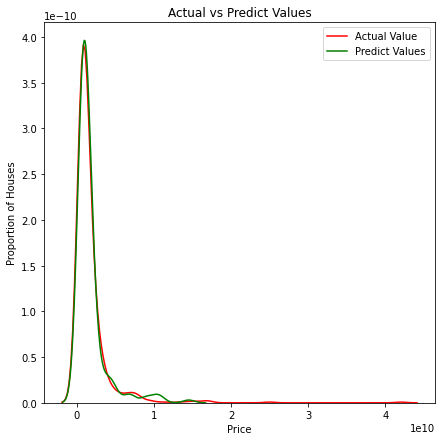

In [18]:
evaluation(knn)

Up to this stage, this method is the most stable method from other methods. In this dataset, we will not use `Decision tree` model because it usually tends to be overfitting, and is devoted for classification problems. So we will try with `Random Forest` because that method will try several tree models, so that will reduce multicollinearity issues and bring up the best performing model.

### 5. Random Forest

In [19]:
rf = RandomForestRegressor()
rf.fit(x_train_scaled, y_train)

RandomForestRegressor()

__Training__
R-squared: 0.944115189564562
MAE: 175261384.70601928
MSE: 3.87089354178389e+17
RMSE: 622165053.8067764
__Validation__
R-squared: 0.8048223151811419
MAE: 482823787.0539529
MSE: 1.5162550034380716e+18
RMSE: 1231363067.2706046


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


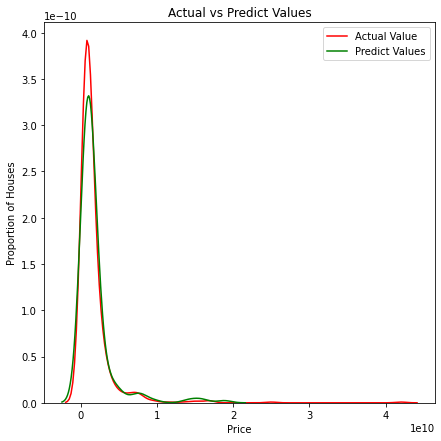

In [20]:
evaluation(rf)

It turns out that the performance is quite large but less stable, and there is still having a multicollinearity issues. Because the model performance is still far from our expected, so we will try a method that is popular for its good performance which is also based on the `Decision Tree` method, that `XGBoost`.

### 6. XGBoost

In [21]:
xgb = XGBRegressor()
xgb.fit(x_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

__Training__
R-squared: 0.9996641520321408
MAE: 25836170.555555556
MSE: 2326270268572041.0
RMSE: 48231424.07779436
__Validation__
R-squared: 0.5980840753079848
MAE: 572193614.1436464
MSE: 3.1223191951543547e+18
RMSE: 1767008544.1656344


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


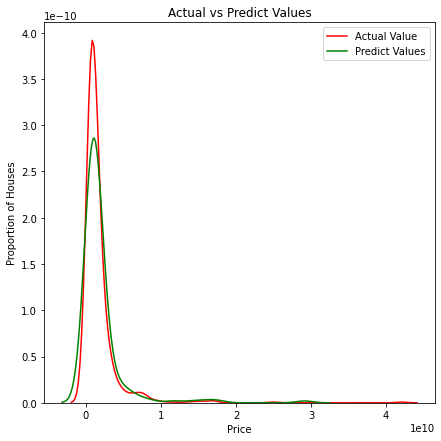

In [22]:
evaluation(xgb)

it's turned out that show large performance but still unstable, and still show multicollinearity issues. We can keep trying to improve performance on a method that is still basic from tree model but is more advanced than `XGBoost`, namely `LightGBM`. 

### 7. LightGBM

In [23]:
lgb = LGBMRegressor()
lgb.fit(x_train_scaled, y_train)

LGBMRegressor()

__Training__
R-squared: 0.806571922715061
MAE: 335426650.4281205
MSE: 1.339790703999865e+18
RMSE: 1157493284.6456885
__Validation__
R-squared: 0.7010167829558633
MAE: 557462317.2601297
MSE: 2.3226774065278894e+18
RMSE: 1524033269.4950886


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


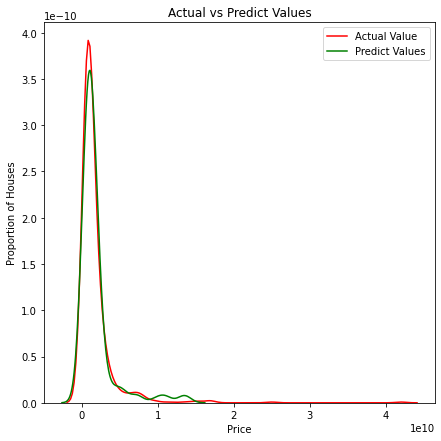

In [24]:
evaluation(lgb)

This model turns out that quite capable to produce a fairly good model performance. 

## Model Comparison

In [25]:
result = pd.DataFrame({
    'Model' : ['Linear Regression','Ridge Regression','Lasso Regression','KNN','Random Forest', 'XGBoost', 'LightGBM'],
    'R-squared' :[0.6732913451243276*100, 0.714063950196598*100, 0.6732913452174213*100, 0.7229611701231738*100, 0.7921627614443715*100, 0.5980840753079848*100, 0.7036921466659144*100],
})

In [26]:
result.sort_values(by='R-squared',ascending= False).reset_index(drop= True)

,Model,R-squared
0,Random Forest,79.216276
1,KNN,72.296117
2,Ridge Regression,71.406395
3,LightGBM,70.369215
4,Lasso Regression,67.329135
5,Linear Regression,67.329135
6,XGBoost,59.808408


After we have tried several methods, then we will compare based on the performance of the test set. The poor performance of the `XGBoost` model may be because the data we have is still small and has many outliers. So next, we will choose the 3 best methods by the best performance because we priotizing the final result. For more explain, Let's make an analogy that is students in class.
<br>

In a class, there are students who are able to learn 10 pictures in a fast time, but there are also students who are able to learn 10 pictures but at a slow time. Here I want to prioritize the final result, no matter how long it takes. So we will choose `Random Forest`, `KNN`, and `Ridge Regression` because it has better performance, although it has some take longer for hyperparameter tuning, with the hope that it will be improve the  model performance.

## Hyperparameter Tuning 

### 1. Random Forest

In [27]:
# Getting the parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

To find out the best parameters we need to be used, we should check our model documentation. If we read the documentation, we can imagine what parameters are suitable for our model. In our case, we want to reduce overfitting issues, although we have to know that the side effect is it will change the overall model accuracy. But we can at least find a balance, where our model is stable and doesn't overfit too much. 
<br>

The parameters that we're going to tune :

- `n_estimator`, A parameter that determines the number of trees in the forest. More trees are means more models to try, so that's possible to find the best performing model
- `max_depth`, the number of maximum depth of the tree. we can limit up the tress to grow, because as it grows, usually the model performance will continue increasing.
- `max_features`, The number of features to consider when looking for the best split. There are 2 methods to be used, first is `Auto/None`. This will simply take all the features which make sense in every tree. Here we simply do not put any restrictions on the individual tree. And second is `sqrt`, This option will take square root of the total number of features in individual run, so it's only takes some features.
- `bootstrap`, Indicates whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
- `min_samples_leaf`, The minimum number of samples required to be at a leaf node. This may have the effect of smoothing the model, especially in regression.
- `min_samples_split`, A parameter that tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it. The default value of the minimum_sample_split is 2. Having a default value is 2 poses the issue that a tree often keeps on splitting until the nodes are completely pure. As a result, the tree grows in size and therefore overfits the data.
<br>

For more documentation is here
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html



In [28]:
# Setting the parameters
rf_grid = {'n_estimators': [10, 20, 40, 60, 80, 100, 120, 150, 180, 200, 300, 350],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'max_features': ['auto', 'sqrt'],
               'bootstrap': [True, False],
               'min_samples_split': [2, 5, 10, 15, 20],
               'min_samples_leaf': [5, 9, 10, 15, 20, 25]
}

rf_rcv = RandomizedSearchCV(rf, rf_grid, n_iter = 500, cv = 5, verbose=1, random_state=42, n_jobs = -1)
rf_rcv.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [5, 9, 10, 15, 20,
                                                             25],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [10, 20, 40, 60, 80,
                                                         100, 120, 150, 180,
                                                         200, 300, 350]},
                   random_state=42, verbose=1)

In [29]:
# Showing the best parameters
rf_rcv.best_params_

{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [30]:
# Best paremeters deployment
rf_tuned = RandomForestRegressor(n_estimators =  10, min_samples_split =  10, min_samples_leaf =  5, max_features = 'sqrt', max_depth = 60, bootstrap = True)
rf_tuned.fit(x_train_scaled, y_train)

RandomForestRegressor(max_depth=60, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=10)

__Training__
R-squared: 0.7544268899254419
MAE: 401362389.68669856
MSE: 1.700976273188891e+18
RMSE: 1304214810.983563
__Validation__
R-squared: 0.7867149416190446
MAE: 501518143.0175274
MSE: 1.6569237268535235e+18
RMSE: 1287215493.5571291


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


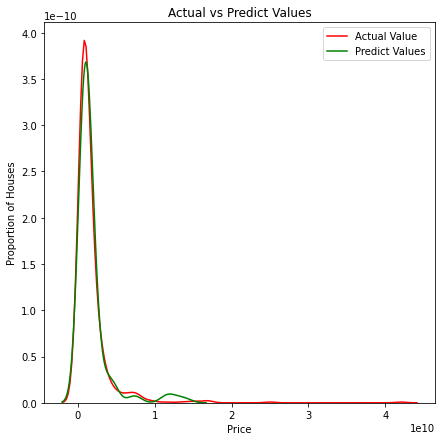

In [31]:
evaluation(rf_tuned)

### 2. KNN

In [32]:
# Getting the parameters
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

The parameters that we need are including :
- `n_neighbors`, Indicate the number of neighbors to use by default for kneighbors queries.
- `leaf_size`, Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree.
- `weights`, Indicate Weight function used in prediction. There are 2 method to be used, first `uniform`, make all points in each neighborhood are weighted equally. And Second is `distance`, weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
- `algorithm`, Indicate what algorithm used to compute the nearest neighbors.
<br>

For more documentation is here https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [33]:
# Setting the parameters
knn_grid = {'n_neighbors': [10, 20, 40, 60, 80, 100, 120, 150, 180, 200, 300, 350],
            'leaf_size':[1,2,3,5],
            'weights':['uniform', 'distance'],
            'algorithm':['auto', 'ball_tree','kd_tree','brute']
}

knn_rcv = RandomizedSearchCV(knn, knn_grid, n_iter = 500, cv = 5, verbose=1, random_state=42, n_jobs = -1)
knn_rcv.fit(x_train_scaled, y_train)

C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 384 is smaller than n_iter=500. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=500, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [1, 2, 3, 5],
                                        'n_neighbors': [10, 20, 40, 60, 80, 100,
                                                        120, 150, 180, 200, 300,
                                                        350],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, verbose=1)

In [34]:
# Showing the best parameters
knn_rcv.best_params_

{'weights': 'distance',
 'n_neighbors': 10,
 'leaf_size': 2,
 'algorithm': 'ball_tree'}

In [35]:
# Best parameters deployment
knn_tuned = KNeighborsRegressor(n_neighbors = 20)
knn_tuned.fit(x_train_scaled,y_train)

KNeighborsRegressor(n_neighbors=20)

__Training__
R-squared: 0.6168478417024864
MAE: 506874458.3333333
MSE: 2.6539254647518746e+18
RMSE: 1629087310.3526018
__Validation__
R-squared: 0.6606916866548689
MAE: 572099337.0165746
MSE: 2.6359464622975135e+18
RMSE: 1623559811.7400892


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


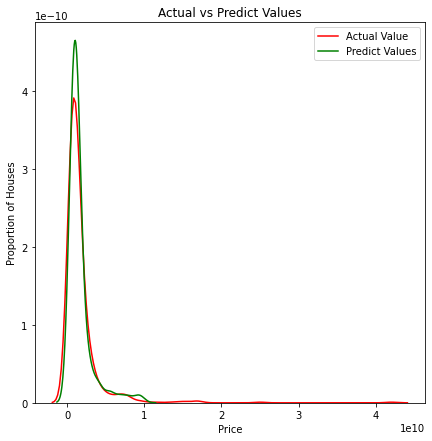

In [36]:
evaluation(knn_tuned)

### 3. Ridge Regression

In [37]:
# Getting the parameters
ridge.get_params()

{'alpha': 100000,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

We will use `alpha` for ridge hyperparameter tuning, because alpha are the regularization parameters. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.
<br>

For more documentation is here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [38]:
# Setting the parameters
ridge_grid = {'alpha': [100000,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
}

ridge_rcv = RandomizedSearchCV(ridge, ridge_grid, n_iter = 500, cv = 5, verbose=1, random_state=42, n_jobs = -1)
ridge_rcv.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=500. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=Ridge(alpha=100000), n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': [100000, 10000, 1000, 100, 10,
                                                  1, 0.1, 0.01, 0.001, 0.0001,
                                                  1e-05, 1e-06]},
                   random_state=42, verbose=1)

In [39]:
# Show the best parameters
ridge_rcv.best_params_

{'alpha': 100}

In [40]:
# Best parameters deployment
ridge_tuned = Ridge(alpha= 100)
ridge_tuned.fit(x_train_scaled,y_train)

Ridge(alpha=100)

__Training__
R-squared: 0.816788170323038
MAE: 535971207.28942853
MSE: 1.2690272772675333e+18
RMSE: 1126511108.36402
__Validation__
R-squared: 0.714063950196598
MAE: 574891837.7838053
MSE: 2.2213193407847823e+18
RMSE: 1490409118.5928721


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


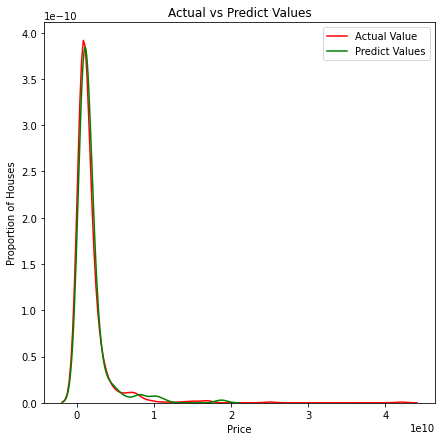

In [41]:
evaluation(ridge)

## Tuned Model Comparison

In [42]:
result_tuned = pd.DataFrame({
    'Model' : ['Random Forest','KNN','Ridge Regression'],
    'R-squared' :[0.8364638366409367*100,0.6606972187807085*100,0.7140639501965977*100],
})

result_tuned = result_tuned.sort_values(by='R-squared',ascending= False).reset_index(drop = True)

In [43]:
result_tuned

,Model,R-squared
0,Random Forest,83.646384
1,Ridge Regression,71.406395
2,KNN,66.069722


After some hyperparameter tuning, it turned out that parameters are able to improve for 'Random Forest' and 'Ridge Regression' performance, although not for the 'KNN' model where was decrease performance. So based on the table above, we can define that `Random Forest` as the method applied to this dataset.

## Feature Importance

Last but not least, we want to see the most of feature importance in this dataset. We can call function named feature_importances_. The more bigger feature importance, the more important it is.

In [ ]:
fe_imp = pd.DataFrame(zip(x.columns, rf_tuned.feature_importances_))
fe_imp = fe_imp.rename({0:'Features', 1:'Importance'}, axis = 'columns')
fe_imp = fe_imp.sort_values(by=['Importance'], ascending = [False]).reset_index(drop = True)

In [ ]:
fe_imp

,Features,Importance
0,surface_area,0.006528
1,tenure,0.001920
2,parking_area,0.000970
3,building_area,0.000068
4,bathroom,0.000002
5,address,0.000000
6,bedroom,0.000000


What we can see?

1. Based on the feature importance table above, 'surface area' is still the most feature that has an effect on the target feature, but it turns out that in this model, 'tenure' and 'parking area' are the features that have quite effect on the target feature.
2. As before, the supporting facilities like bedrooms and bathrooms aren't important yet, but it turns out that in this model, 'address' isn't too much effect the target feature. So, 'Surface Area' and 'Tenure' statuses are the most important features for determining the selling value of a house in Cimahi and its surroundings.

## Conclusion

- The regression model that we choose to model our data is `Random Forest Regressor`. We have verified in the test set that this model shows a high accuracy and less overfitting issues compared to other models.
- The top feature that affects the selling price of houses in Cimahi and its surrounding is 'Surface Area'. So Cimahi people think'the bigger surface area, the higher land or house value'.
- Surprisingly, that tenure statuses has a quite high effect to house price, so we can assume that if the house is legal and is private ownership, it will be an added value and more higher the selling price value.
- Last, it turns out that 'Address' doesn't have an effect on the house selling price, maybe because Cimahi people are just seeing the Surface Area, no matter where the location is.

Thank you very much for your attention and time, I hope this research can provide useful information :)